In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import time
import warnings

from datetime import datetime
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNetCV, ElasticNet
from sklearn.feature_selection import SelectKBest, RFE,RFECV, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [2]:
# Suppress Warning message

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    

def log_msg(message):
    print(str(datetime.now()) + ": " + message)


In [3]:
train_df=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")


# Feature Selection

## Drop the missing values

In [4]:
# Drop columns with more than 80% of missing values

missing_val_df=(train_df.isnull().sum() / len(train_df)).sort_values(ascending=False)
missing_features = missing_val_df[missing_val_df > 0.80].index
train_df.drop(missing_features, axis=1, inplace=True)


train_df["FireplaceQu"].fillna("NA", inplace = True)

(train_df.isnull().sum() / len(train_df)).sort_values(ascending=False)

LotFrontage     0.177397
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
                  ...   
BsmtUnfSF       0.000000
TotalBsmtSF     0.000000
MSSubClass      0.000000
HeatingQC       0.000000
SalePrice       0.000000
Length: 77, dtype: float64

In [5]:
# Drop the rest of the rows with null values
train_df.dropna(inplace = True)

## Drop the zero variance columns

In [6]:
# remove coloumns with constant values
train_df = train_df.loc[:, (train_df != train_df.iloc[0]).any()] 
print(train_df.shape)

(1094, 76)


## Correlation analysis

### Correlation among the features

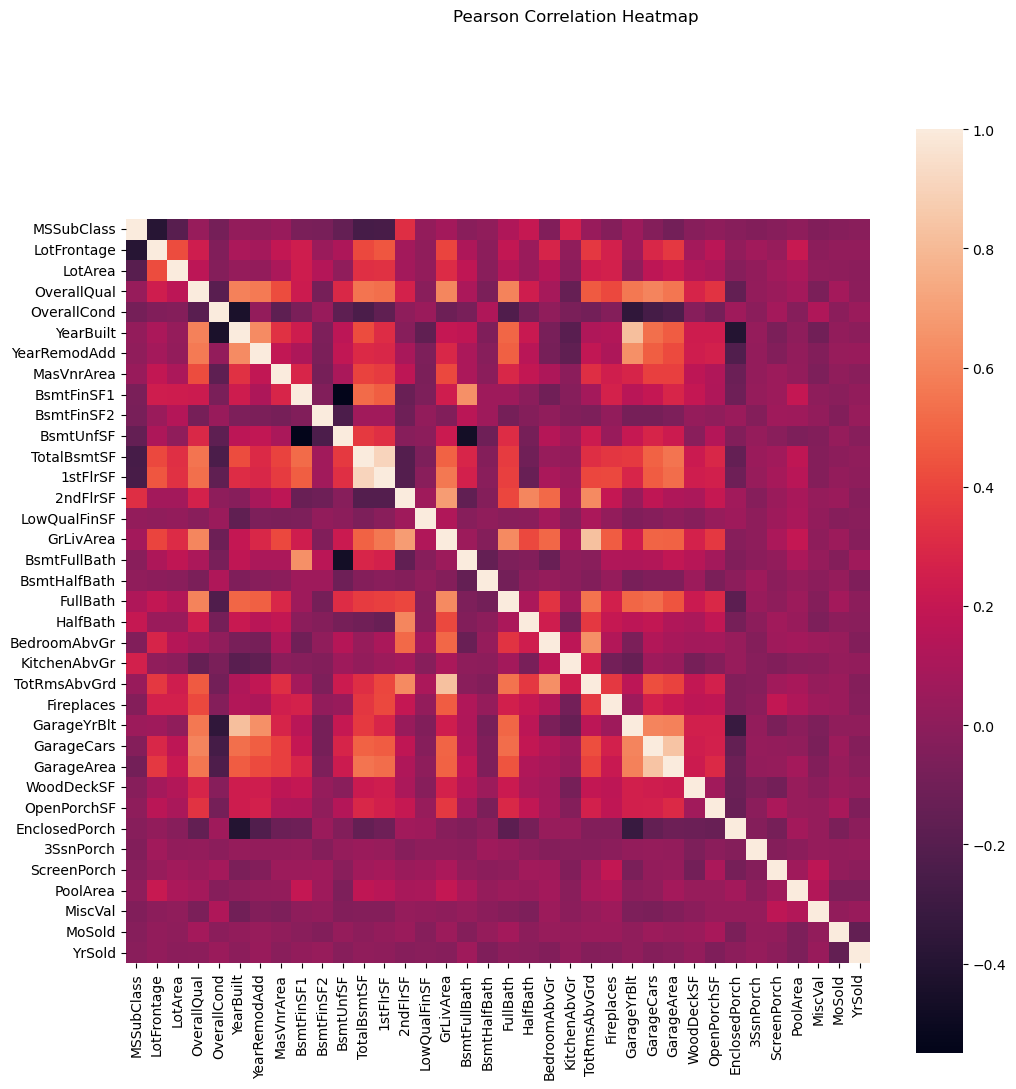

In [7]:
# Check for correlation with the Numeric features
train_df_nid = train_df.drop(['Id'],axis=1)
pd.set_option('precision',2)
plt.figure(figsize=(12,12))

sns.heatmap(train_df_nid.drop(['SalePrice'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show()

In [8]:
# Create correlation matrix
corr_matrix = train_df_nid.drop(['SalePrice'],axis=1).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# select one feature from the highly correlated features, threshold 0.6
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

print(to_drop)

# drop the selected feattures that are correlated with anothoer feature
train_df_nid.drop(to_drop, axis=1, inplace=True)

['YearRemodAdd', '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea']


### Correlation with the target Variable

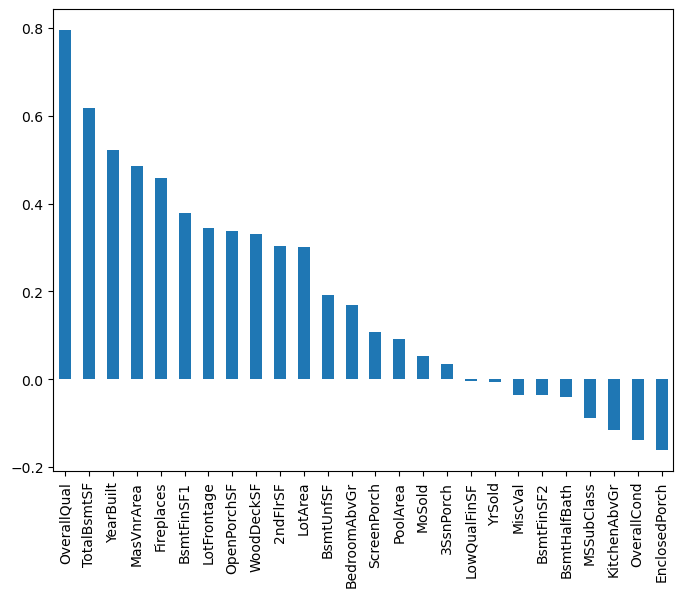

In [9]:
corr_with_tot_count = train_df_nid.corr()["SalePrice"].sort_values(ascending=False)

plt.figure(figsize=(8,6))
corr_with_tot_count.drop("SalePrice").plot.bar()
plt.show()

In [10]:
train_df_nid.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '2ndFlrSF',
       'LowQualFinSF', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition',
       'SalePrice'],
     

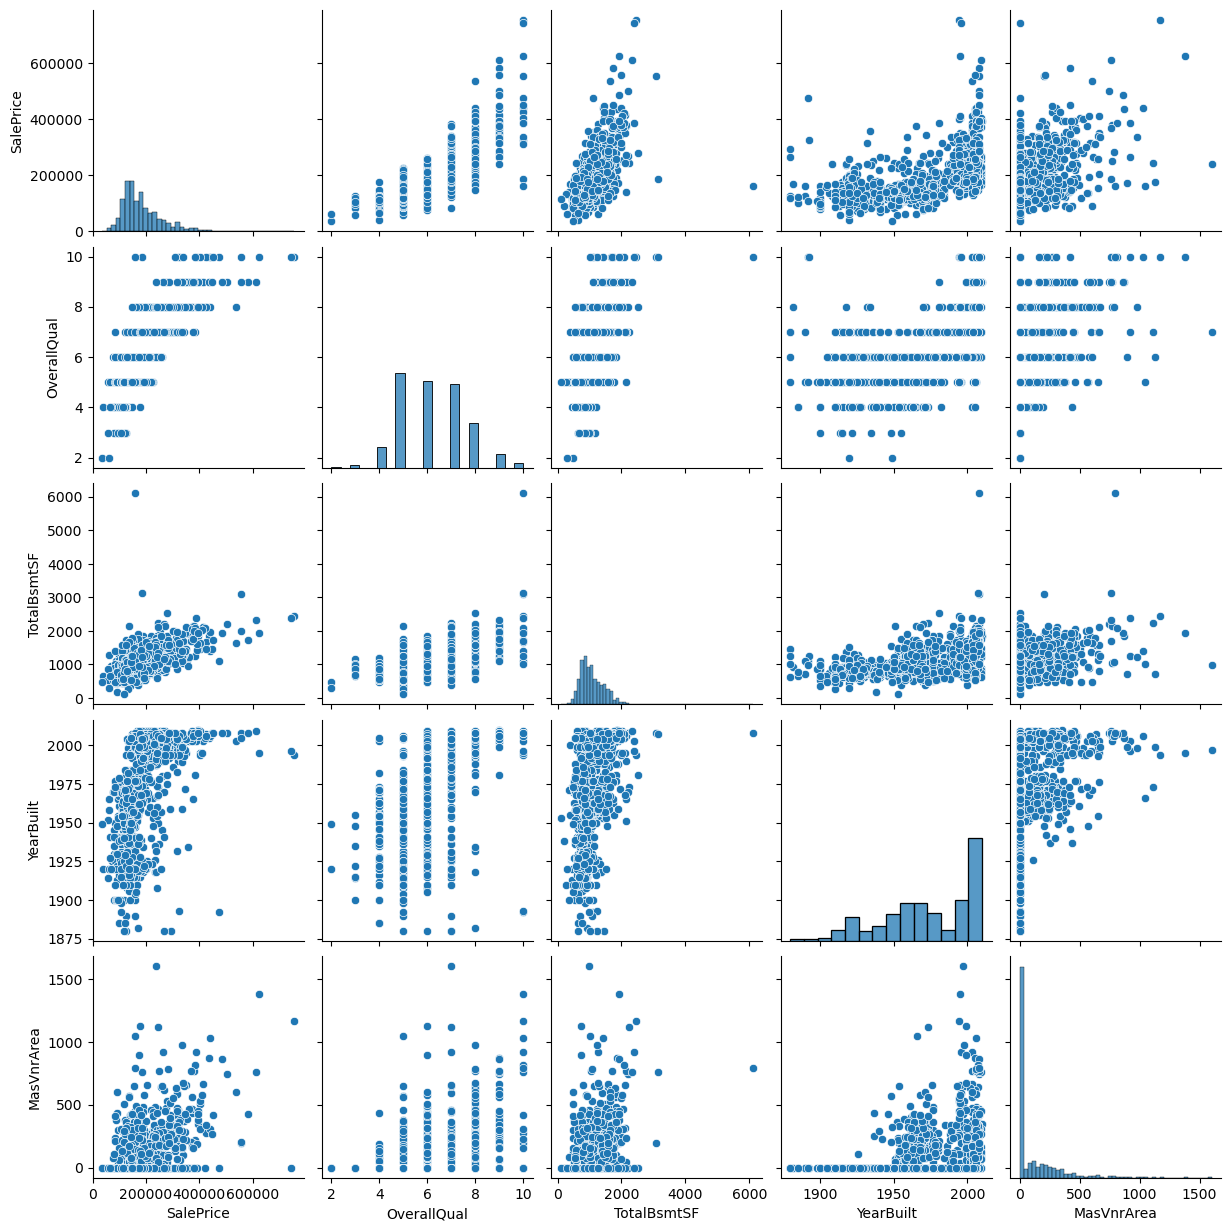

In [11]:
sns.pairplot(train_df_nid[['SalePrice', 'OverallQual', 'TotalBsmtSF', 'YearBuilt','MasVnrArea']])
plt.show()